# Advanced Sentiment Analysis


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
from transformers import pipeline
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('stopwords')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load and preprocess dataset
df = pd.read_csv("zomato_reviews.csv")
df['review'] = df['review'].astype(str)

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_review'] = df['review'].apply(clean_text)

In [4]:
# Create polarity and labels (TextBlob)
df['polarity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['label'] = df['polarity'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df_binary = df[df['label'] != 0]  # Exclude neutral for binary classification
print("Label distribution:", df_binary['label'].value_counts())

Label distribution: label
 1    2326
-1    1692
Name: count, dtype: int64


In [5]:
# BERT sentiment prediction
sentiment_pipeline = pipeline("sentiment-analysis")

def batch_sentiment_analysis(reviews, batch_size=32):
    results = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        results.extend(sentiment_pipeline(batch))
    return results

df_sample = df.sample(500, random_state=42).copy()
bert_results = batch_sentiment_analysis(df_sample['review'].tolist())
df_sample['bert_sentiment'] = [res['label'] for res in bert_results]
df_sample['sentiment_label'] = df_sample['bert_sentiment'].map({'NEGATIVE': -1, 'POSITIVE': 1})

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


⚠️ NOTE: This is a proxy evaluation comparing BERT to TextBlob-generated labels.
Label Distribution:
TextBlob label: {1: 209, -1: 157}
BERT label:     {-1: 189, 1: 177}

Accuracy of BERT vs TextBlob Label: 0.9016393442622951

Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.99      0.90       157
           1       0.99      0.84      0.91       209

    accuracy                           0.90       366
   macro avg       0.90      0.91      0.90       366
weighted avg       0.92      0.90      0.90       366



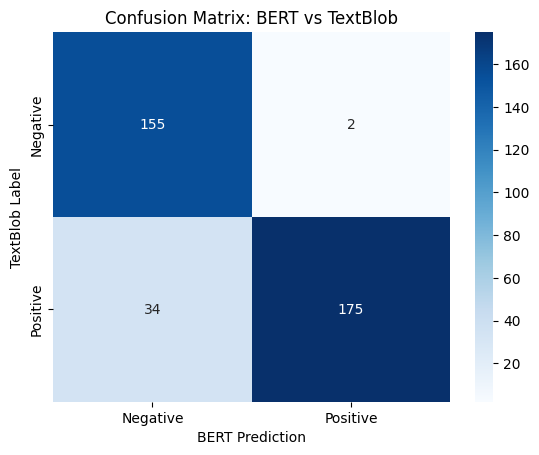

In [6]:
# Evaluate BERT vs TextBlob label agreement
# Ensure labels exist

# Create TextBlob labels directly on the sample dataframe
# This avoids the issues with merging filtered dataframes
df_sample['polarity'] = df_sample['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sample['label'] = df_sample['polarity'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Now filter the sample to match the binary classification scope
# This ensures we only compare BERT/TextBlob on non-neutral reviews in the sample
merged = df_sample[df_sample['label'] != 0].copy()

# Ensure sentiment_label exists for the comparison
# This was already done, but added here for clarity within this block's context
# merged['sentiment_label'] = merged['bert_sentiment'].map({'NEGATIVE': -1, 'POSITIVE': 1})


print("⚠️ NOTE: This is a proxy evaluation comparing BERT to TextBlob-generated labels.")
print("Label Distribution:")
# Now 'label' and 'sentiment_label' should exist in the merged dataframe
print("TextBlob label:", merged['label'].value_counts().to_dict())
print("BERT label:    ", merged['sentiment_label'].value_counts().to_dict())

print("\nAccuracy of BERT vs TextBlob Label:", accuracy_score(merged['label'], merged['sentiment_label']))
print("\nClassification Report:")
print(classification_report(merged['label'], merged['sentiment_label']))

# Confusion Matrix
cm = confusion_matrix(merged['label'], merged['sentiment_label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel("BERT Prediction")
plt.ylabel("TextBlob Label")
plt.title("Confusion Matrix: BERT vs TextBlob")
plt.show()

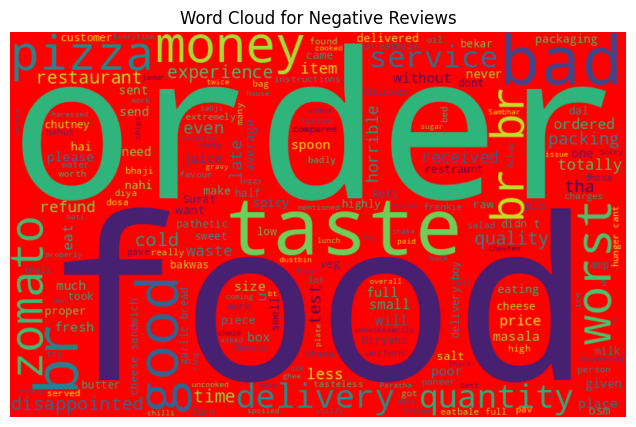

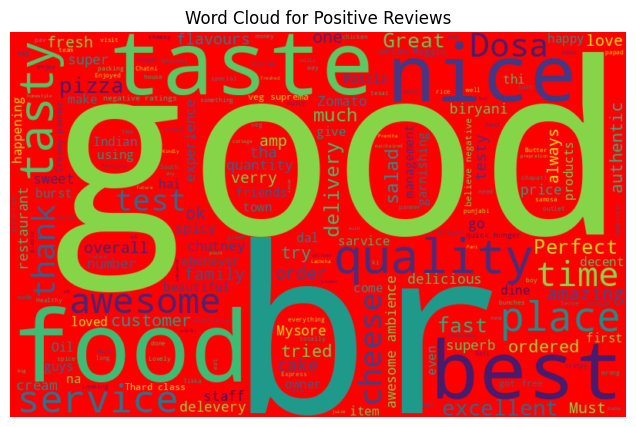

In [7]:
# WordCloud by BERT sentiment
for label, name in zip([-1, 1], ['Negative', 'Positive']):
    subset = df_sample[df_sample['sentiment_label'] == label]
    text = ' '.join(subset['review'])
    wordcloud = WordCloud(width=800, height=500, background_color='Red').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {name} Reviews')
    plt.axis('off')
    plt.show()

In [8]:
# Traditional ML sentiment analysis
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_binary['clean_review'])
y = df_binary['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.85      0.87       330
           1       0.90      0.93      0.91       474

    accuracy                           0.90       804
   macro avg       0.90      0.89      0.89       804
weighted avg       0.90      0.90      0.90       804

Confusion Matrix:
[[281  49]
 [ 34 440]]


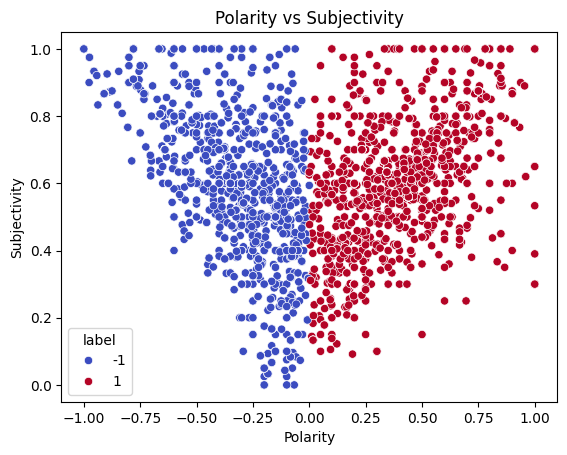

In [9]:
# Polarity vs Subjectivity
df_binary['subjectivity'] = df_binary['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
sns.scatterplot(data=df_binary, x='polarity', y='subjectivity', hue='label', palette='coolwarm')
plt.title("Polarity vs Subjectivity")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()